In [1287]:
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.statespace.tools import diff

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
import itertools
import emcee, corner

from scipy.stats import shapiro

## First, let's look at ARIMA and SARIMA with an easily-predictable time series, monthly temperatures in Montreal!

In [2]:
# This function adds up all csv data files

def add(df, year):
    temp_df = pd.read_csv('data/monthly_' + str(year) + '_data.csv')
    
    df = df.append(temp_df, ignore_index=True)
    
    return df

In [292]:
# Load all weather data

df_weather = pd.read_csv('data/monthly_2012_data.csv')
for i in range(2013, 2021):
    df_weather = add(df_weather, i)
    

# Clean df to only keep what we need

df_weather = df_weather[['Date', 'Mean Temp']]
df_weather.index = df_weather['Date']
df_weather.drop(columns=['Date'], axis=0, inplace=True)

In [364]:
#df_weather

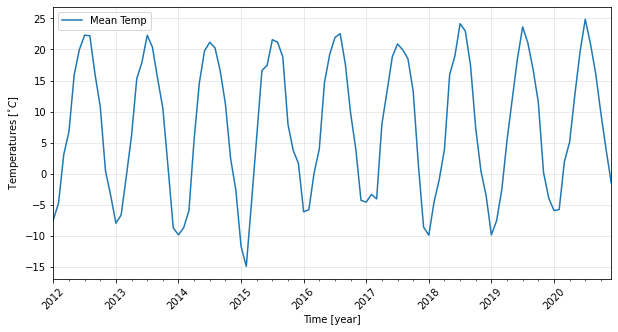

In [547]:
# let's visualize this

df_weather.plot(figsize=(10,5))
plt.xlabel('Time [year]')
plt.ylabel('Temperatures [$^{\circ} C$]');
plt.xticks(rotation=45);
plt.grid(alpha=0.3)
plt.show()

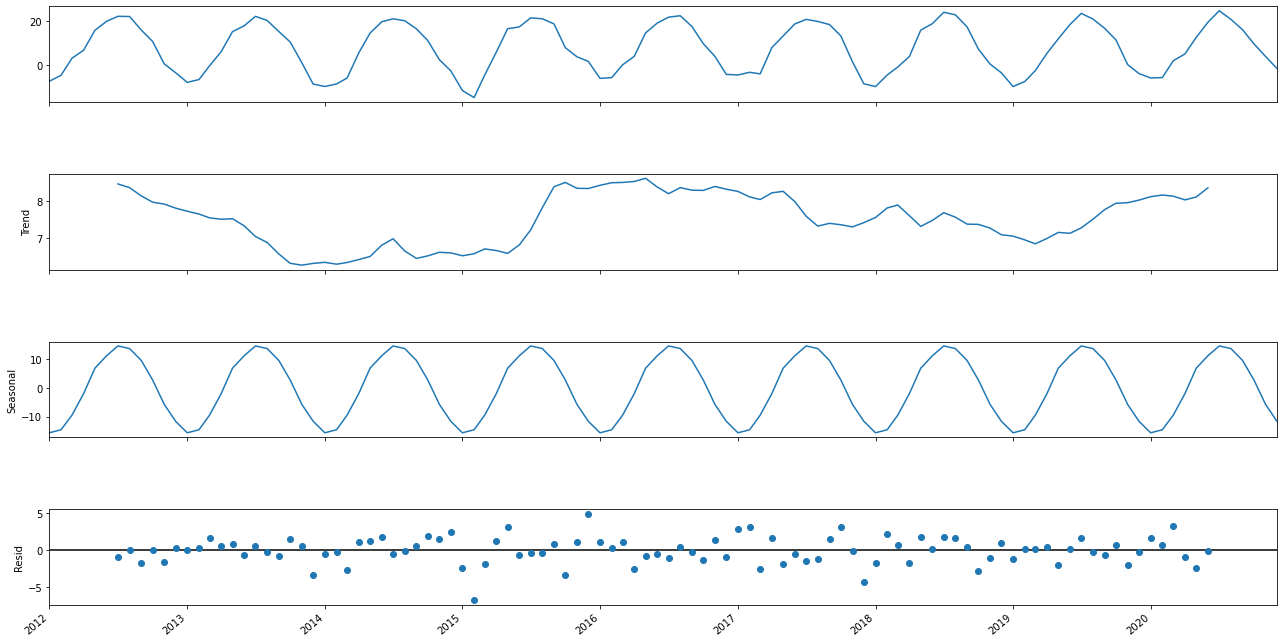

In [1142]:
# Let's look at the decomposition of the data
# clearly from the plot there's a seasonality in the data, and we know that temperatures
# vary with a period of 12 months

decomposed_fig = seasonal_decompose(df_weather, period=12)
fig = decomposed_fig.plot()
fig.set_size_inches((20, 11))
fig.autofmt_xdate(rotation=40);
#plt.xticks([0, 20, 40, 60, 80, 100]);

## The decomposition shows the trend of the data, any seasonal cycles, and residuals, which are fluctuations which cannot be explained by the two former features.

The fact that there is a very strong seasonal component to this time series means it can be predicted very reliably.

# Let's test the series for stationarity with the ADF test:

In [263]:
print('p-Value for ADF test:', adfuller(df_weather)[1])

p-Value for ADF test: 0.4918248687178772


### p-value is bigger than 0.05, so the series is *not* stationary. Let's see if differencing it once will make it stationary:

In [264]:
df_weather_diff = diff(df_weather)
print('p-Value for ADF test:', adfuller(df_weather_diff)[1])

p-Value for ADF test: 2.411861523587474e-12


### Yes, the first difference of the series is stationary, so we'll use a first order of (seasonal) differencing for the SARIMA model.

In [510]:
# find period of seasonal cycle
def series_period(series):
    correlation = np.correlate(series, series, 'full')[-len(series):]
    inflection = np.diff(np.sign(np.diff(correlation)))
    peaks = (inflection < 0).nonzero()[0] + 1
    return peaks[correlation[peaks].argmax()]

In [265]:
series_period(df_weather['Mean Temp'])

12

### Look at ACF and PACF

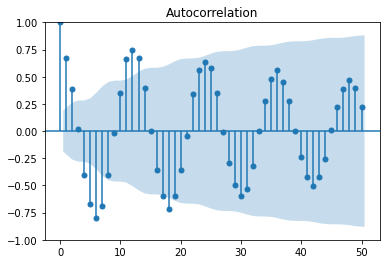

In [266]:
plot_acf(df_weather_diff, lags=50); # ACF of undifferenced series looks the same
# A decaying oscillation is a hint the series might be autoregressive

### ACF peaks at lag 12, meaning after 1 year. We know the seasonality has a period of 12,  so let's start with sMA order 1

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


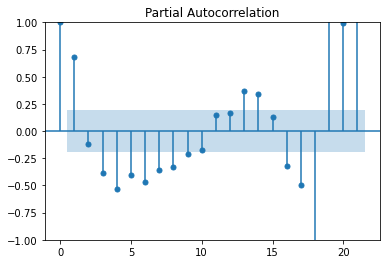

In [267]:
plot_pacf(df_weather_diff); # Peak at lag 1, maybe AR(1)?

### Let's try to minimize the AIC of a number of reasonable guesses:

In [595]:
# Brute force method to find appropriate sarima model by finding lowest AIC
def brute_force_sarima(df, p_max, d_max, q_max, S=12):
    p = range(0, p_max+1)
    d = range(0,d_max+1)
    q = range(0, q_max+1)
    
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], S) for x in list(itertools.product(p, d, q))]
    
    # Make a deep copy of the df so the frequency setting does not affect the
    # original df
    df_copy = pd.DataFrame.copy(df)
    
    # Set frequency for the df
    if S == 12:
        df_copy = df.asfreq('MS')
    if S == 7:
        df_copy = df.asfreq('W')
        
    my_dict = {}
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = SARIMAX(df_copy, order=param, seasonal_order=param_seasonal)
                results = mod.fit(disp=0);
                my_dict[results.aic] = ('SARIMA{}x{}'.format(param,param_seasonal))
            except: 
                continue
    return sorted(my_dict.items(), key=lambda item: item[0])[:5]

In [491]:
brute_force_sarima(df_weather[:-2*12], 1, 1, 1,12)

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[(339.7842862533862, 'SARIMA(0, 0, 1)x(0, 1, 1, 12)'),
 (341.0610741364118, 'SARIMA(1, 0, 0)x(0, 1, 1, 12)'),
 (341.62926989030757, 'SARIMA(0, 0, 1)x(1, 1, 1, 12)'),
 (341.6826059642218, 'SARIMA(1, 0, 1)x(0, 1, 1, 12)'),
 (342.82154963884005, 'SARIMA(1, 0, 0)x(1, 1, 1, 12)')]

### Even though we looked at ACF and PACF, it seems like the parameters that minimize the AIC and yield the best prediction are (0,0,1)x(0,1,1,12), so let's stick to these

In [449]:
weather_sarima_model = SARIMAX(df_weather[:-2*12], order=(0,0,1), seasonal_order=(0,1,1,12))
weather_sarima_model_fit = weather_sarima_model.fit()
weather_forecast_sarima = weather_sarima_model_fit.forecast(2*12)
weather_conf_intervals = weather_sarima_model_fit.get_forecast(2*12).conf_int(alpha=0.05)

weather_sarima_model_fit.summary()

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.05768D+00    |proj g|=  1.23521D-01

At iterate    5    f=  1.98973D+00    |proj g|=  7.81561D-03

At iterate   10    f=  1.98709D+00    |proj g|=  4.39766D-03

At iterate   15    f=  1.98684D+00    |proj g|=  4.99362D-04

At iterate   20    f=  1.98681D+00    |proj g|=  2.90748D-04

At iterate   25    f=  1.98681D+00    |proj g|=  1.06515D-04

At iterate   30    f=  1.98681D+00    |proj g|=  1.63850D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Mean Temp   No. Observations:                   84
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -166.892
Date:                            Wed, 13 Apr 2022   AIC                            339.784
Time:                                    10:22:07   BIC                            346.614
Sample:                                01-01-2012   HQIC                           342.503
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3643      0.091      3.990      0.000       0.185       0.543
ma.S.L12      -0.9994    106.947     -0.009      0.993    -210.612     208.614
sigma2         4.3596    465.733      0.009      0.993    -908.460     917.180
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.22
Prob(Q):                              0.92   Prob(JB):                         0.54
Heteroskedasticity (H):               1.69   Skew:                            -0.31
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

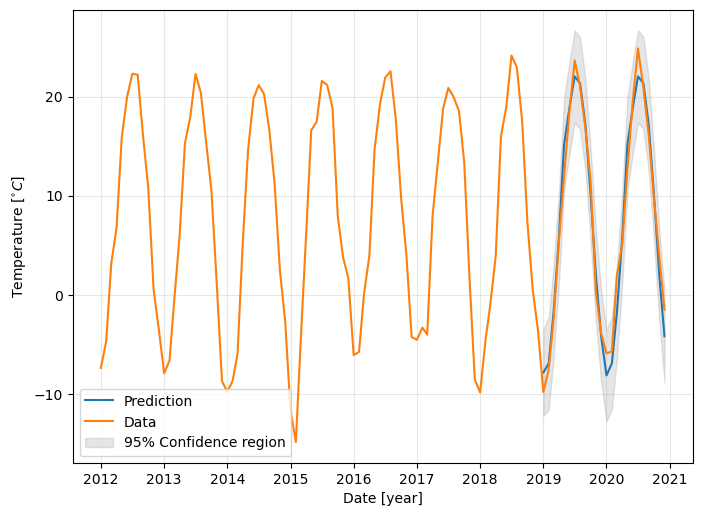

In [546]:
df_weather.index = pd.to_datetime(df_weather.index)

plt.figure(figsize=(8,6), dpi=100)
plt.plot(weather_forecast_sarima, label='Prediction')
plt.plot(df_weather, label='Data')
plt.fill_between(weather_conf_intervals.index, weather_conf_intervals['lower Mean Temp'], 
                 weather_conf_intervals['upper Mean Temp'], color='gray', alpha=0.2, label='95% Confidence region')

plt.legend()
plt.grid(alpha=0.3)
plt.xlabel('Date [year]')
plt.ylabel('Temperature [$^{\circ} C$]');

## This looks like a pretty good prediction of the last 2 years.
## Residuals for the prediction:

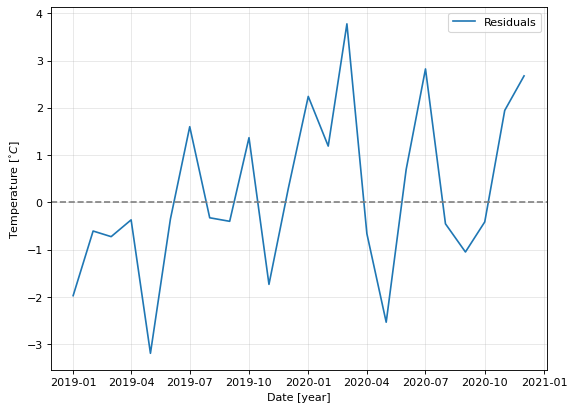

In [1284]:
plt.figure(figsize=(8,6), dpi=80)
plt.plot(df_weather.index[-2*12:], df_weather['Mean Temp'][-2*12:] - weather_forecast_sarima, label='Residuals');
plt.axhline(0, linestyle='--', color='grey')
plt.legend()
plt.grid(alpha=0.3)
plt.xlabel('Date [year]')
plt.ylabel('Temperature [$^{\circ} C$]');

In [1283]:
# Shapiro test of normality: p-value > 0.5 => data is normally distributed!
shapiro((df_weather['Mean Temp'][-2*12:] - weather_forecast_sarima))

ShapiroResult(statistic=0.9688391089439392, pvalue=0.6384040117263794)

## Residuals are well-distributed around zero.

# Now, let's look at a SARIMA prediction for a time series with a pronounced trend:

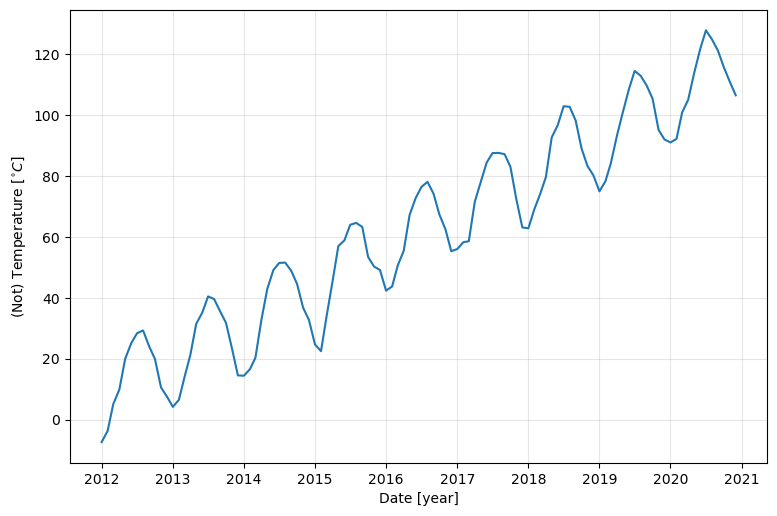

In [1133]:
df_trend = pd.DataFrame.copy(df_weather)

df_trend['Mean Temp'] += np.linspace(0, len(df_trend), len(df_trend))

# Let's see transformed time series
plt.figure(figsize=(9,6), dpi=100)
plt.plot(df_trend)
plt.grid(alpha=0.3)
plt.xlabel('Date [year]')
plt.ylabel('(Not) Temperature [$^{\circ} C$]');
#plt.xticks([10*x for x in range(0,11)],rotation=45);

Period of seasonality: 12


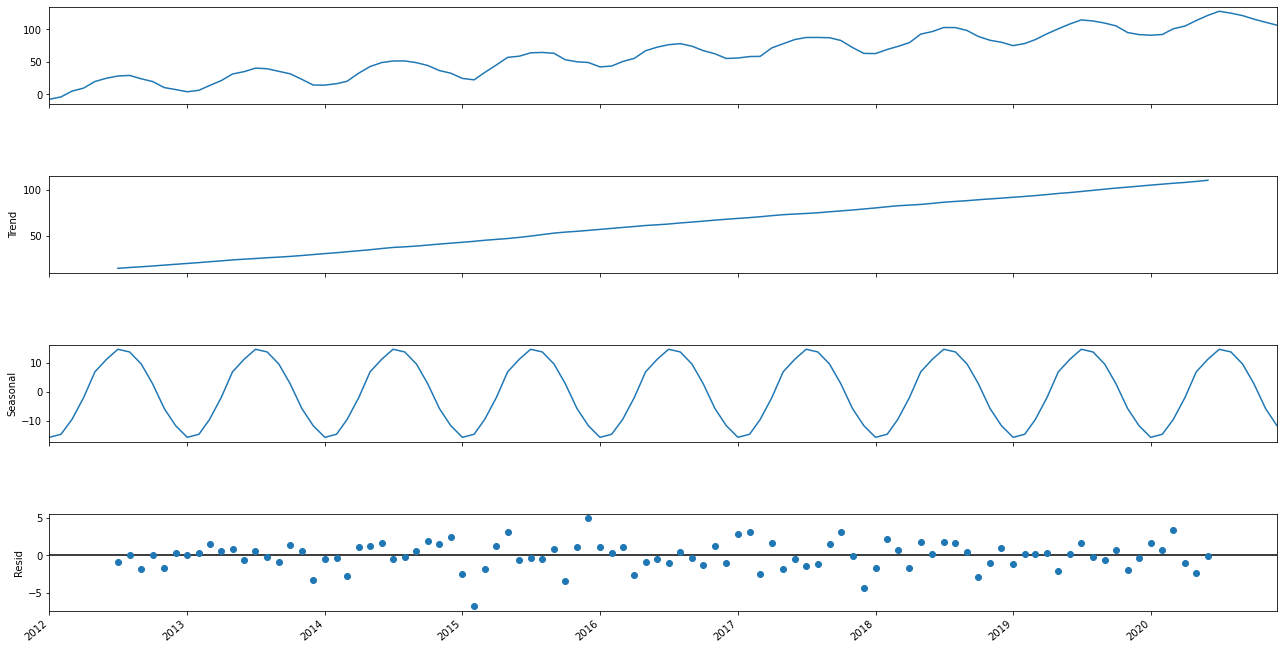

In [1144]:
fig = seasonal_decompose(df_trend).plot()
fig.set_size_inches((20, 11))
fig.autofmt_xdate(rotation=40);
#plt.xticks([0, 20, 40, 60, 80, 100]);

print('Period of seasonality:', series_period(seasonal_decompose(df_trend).seasonal))

## Use a broot force approach that computes many different SARIMA models and records their AIC, so the lowest AIC model can be found

In [492]:
brute_force_sarima(df_trend[:-2*12], 1, 1, 1)

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive pa

[(344.328784844737, 'SARIMA(1, 1, 1)x(0, 1, 1, 12)'),
 (346.04526842825646, 'SARIMA(1, 1, 1)x(1, 1, 1, 12)'),
 (346.13120895234636, 'SARIMA(0, 1, 1)x(0, 1, 1, 12)'),
 (347.36237731759087, 'SARIMA(0, 1, 1)x(1, 1, 1, 12)'),
 (355.91888085412904, 'SARIMA(1, 0, 1)x(0, 1, 1, 12)')]

In [494]:
trend_sarima_model = SARIMAX(df_trend[:-2*12], order=(1,1,1), seasonal_order=(0,1,1,12))
trend_sarima_model_fit = trend_sarima_model.fit()
trend_forecast_sarima = trend_sarima_model_fit.forecast(2*12)
conf_intervals = trend_sarima_model_fit.get_forecast(2*12).conf_int(alpha=0.05)

trend_sarima_model_fit.summary()

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.10700D+00    |proj g|=  1.32686D-01

At iterate    5    f=  2.00498D+00    |proj g|=  1.81551D-02

At iterate   10    f=  2.00271D+00    |proj g|=  1.23710D-02

At iterate   15    f=  2.00204D+00    |proj g|=  1.53592D-03

At iterate   20    f=  2.00197D+00    |proj g|=  4.75865D-04

At iterate   25    f=  2.00196D+00    |proj g|=  2.91412D-04

At iterate   30    f=  2.00196D+00    |proj g|=  9.57990D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Mean Temp   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -168.164
Date:                            Wed, 13 Apr 2022   AIC                            344.329
Time:                                    11:06:56   BIC                            353.380
Sample:                                01-01-2012   HQIC                           347.928
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2659      0.168      1.582      0.114      -0.063       0.595
ma.L1         -0.9123      0.097     -9.398      0.000      -1.103      -0.722
ma.S.L12      -0.9985     45.227     -0.022      0.982     -89.642      87.645
sigma2         4.6954    211.697      0.022      0.982    -410.223     419.614
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.98
Prob(Q):                              0.92   Prob(JB):                         0.37
Heteroskedasticity (H):               1.79   Skew:                            -0.41
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

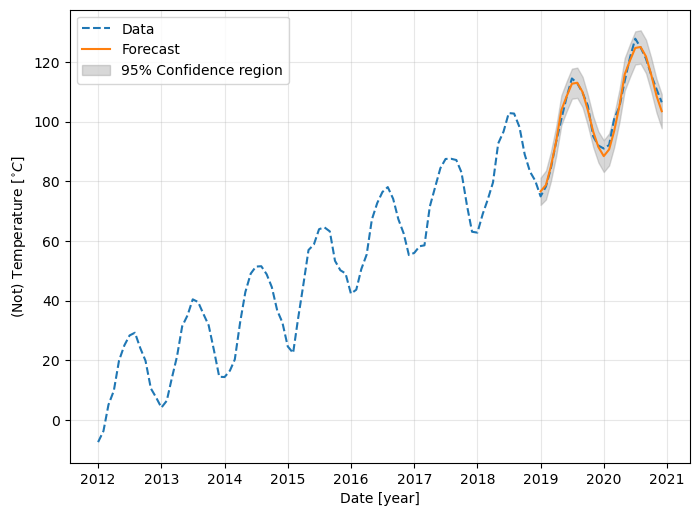

In [541]:
df_trend.index = pd.to_datetime(df_trend.index)

plt.figure(figsize=(8,6), dpi=100)
plt.plot(df_trend, '--', label='Data')
plt.plot(trend_forecast_sarima, label='Forecast')
plt.fill_between(conf_intervals.index, conf_intervals['lower Mean Temp'], 
                 conf_intervals['upper Mean Temp'], color='gray', alpha=0.3, label='95% Confidence region')

plt.legend()
plt.grid(alpha=0.3)
plt.xlabel('Date [year]')
plt.ylabel('(Not) Temperature [$^{\circ} C$]');

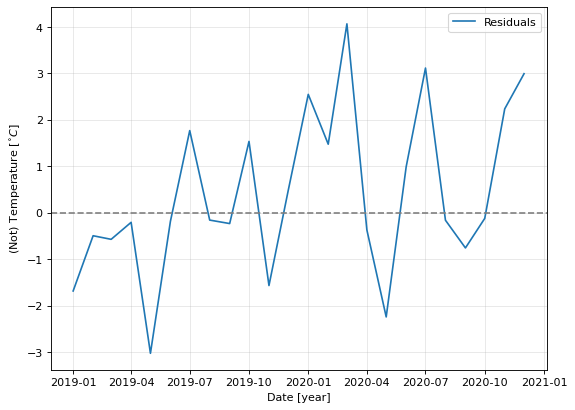

In [540]:
plt.figure(figsize=(8,6), dpi=80)
plt.plot(df_weather.index, df_trend['Mean Temp'] - trend_forecast_sarima, label='Residuals');
plt.axhline(0, linestyle='--', color='grey')
plt.legend()
plt.grid(alpha=0.3)
plt.xlabel('Date [year]')
plt.ylabel('(Not) Temperature [$^{\circ} C$]');
#plt.xticks([85, 90, 95, 100, 105], rotation=45);

In [1285]:
shapiro((df_trend['Mean Temp'][-2*12:] - trend_forecast_sarima))
# pvalue > 0.5 => data is normally distributed! (good for residuals)

ShapiroResult(statistic=0.9666193127632141, pvalue=0.584682047367096)

## For a time series with a strong seasonal and trend components compared to the residuals, SARIMA does a pretty good job predicting even a large time interval.

## This is not the case with more noise signals, such as stocks for example.

In [1154]:
# Let's look at S&P 500 stock, which combines 500 of the biggest companies in the US
tickData = yf.Ticker('SPY')

# Full data set 1993 to 2022
df_full = tickData.history(period='1d', start='1990-1-1', end='2022-1-1')
# This line reindexes the df so that the date is the index, and interpolates any missing values
df_full = df_full['Close'].reindex(pd.date_range(df_full.index[0], df_full.index[-1]), fill_value=None).interpolate()

# We will restrict the actual model to the period 2010-2022
df = tickData.history(period='1d', start='2010-1-1', end='2022-1-1')
df = df['Close'].reindex(pd.date_range(df.index[0], df.index[-1]), fill_value=None).interpolate()

# Testing data is 2020 and 2021
df_testing = tickData.history(period='1d', start='2020-1-1', end='2022-1-1')
df_testing = df_testing['Close'].reindex(pd.date_range(df_testing.index[0], df_testing.index[-1]), fill_value=None).interpolate()

# Training data with no knowledge of covid crash
df_training = tickData.history(period='1d', start='2010-1-1', end='2020-1-1')
df_training = df_training['Close'].reindex(pd.date_range(df_training.index[0], df_training.index[-1]), fill_value=None).interpolate()

# Training data with knowledge of covid crash
#df = tickData.history(period='1d', start='2010-1-1', end='2020-3-24')

In [597]:
df

2010-01-04     89.610855
2010-01-05     89.848038
2010-01-06     89.911293
2010-01-07     90.290848
2010-01-08     90.591309
                 ...    
2021-12-27    475.781921
2021-12-28    475.393127
2021-12-29    476.001251
2021-12-30    474.685333
2021-12-31    473.489044
Freq: D, Name: Close, Length: 4380, dtype: float64

Text(0, 0.5, 'Stock price (USD)')

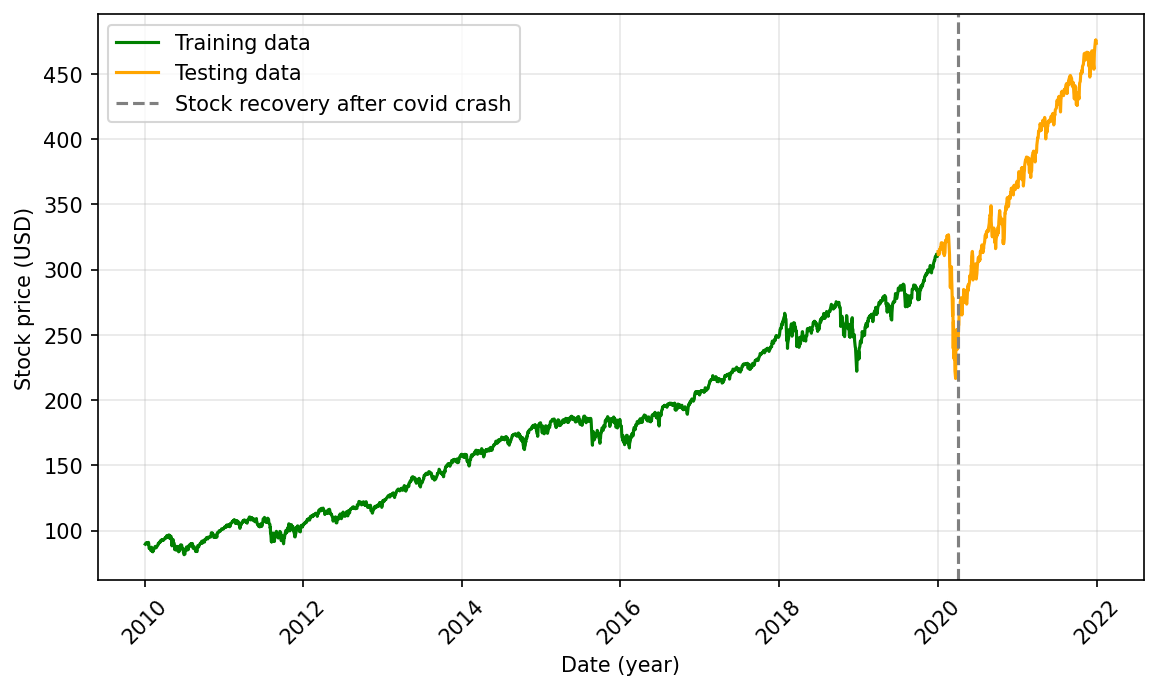

In [1150]:
# Let's visualize the data
plt.figure(figsize=(9,5), dpi=150)
#plt.plot(df)
plt.plot(df_training, color='green', label='Training data')
plt.plot(df_testing, color='orange', label='Testing data')
plt.xticks(rotation=45);
plt.axvline(datetime(2020,4,1), color='grey', linestyle='--', label='Stock recovery after covid crash')

covid_recovery_date = datetime(2020, 4, 1)

plt.grid(alpha=0.3)
plt.legend()
plt.xlabel('Date (year)')
plt.ylabel('Stock price (USD)')

### The series has a lot of jumps up and down (volatility). Let's look at its first difference:

Text(0.5, 0, 'Time (years)')

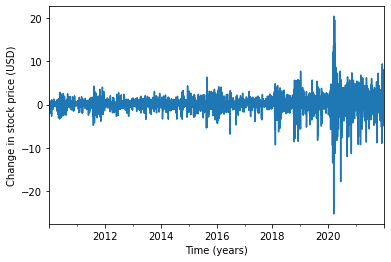

In [599]:
diff(df).plot()
plt.ylabel('Change in stock price (USD)')
plt.xlabel('Time (years)')

There is certainly a lot of volatility in this series, especially around 2020, when the covid pandemic cause a huge crash. 

The series is not stationary, doesn't appear to be seasonal, and looks very difficult to predict. Trend is not constant either.

### Let's decompose it

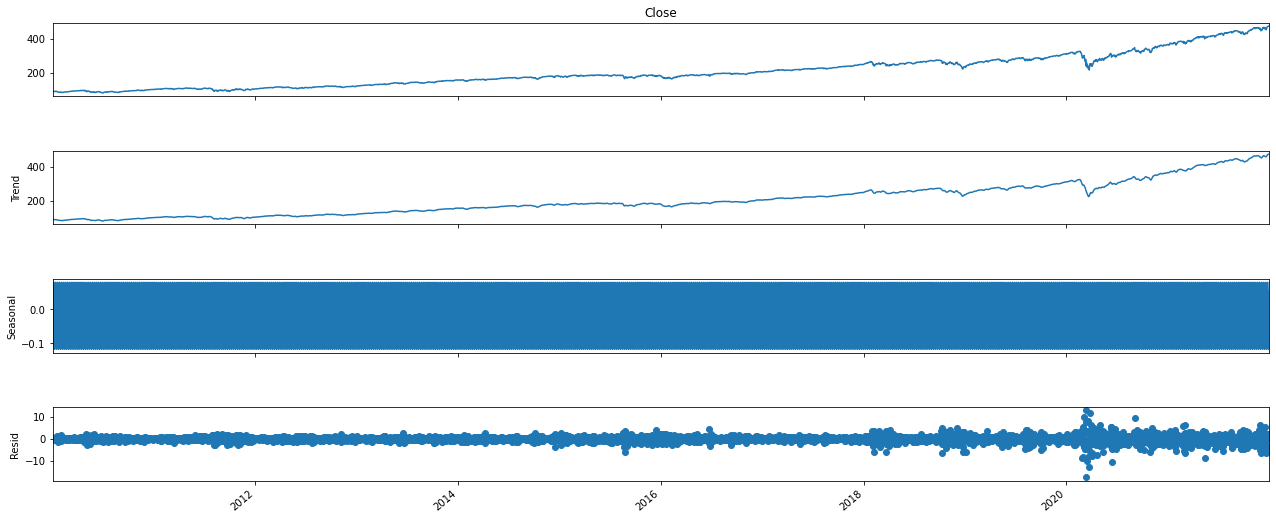

In [601]:
decomposed_fig = seasonal_decompose(df)
fig = decomposed_fig.plot()
fig.set_size_inches((20, 9))
fig.autofmt_xdate(rotation=40);

## The seasonal component looks weird. Let's look at a subset of the series:

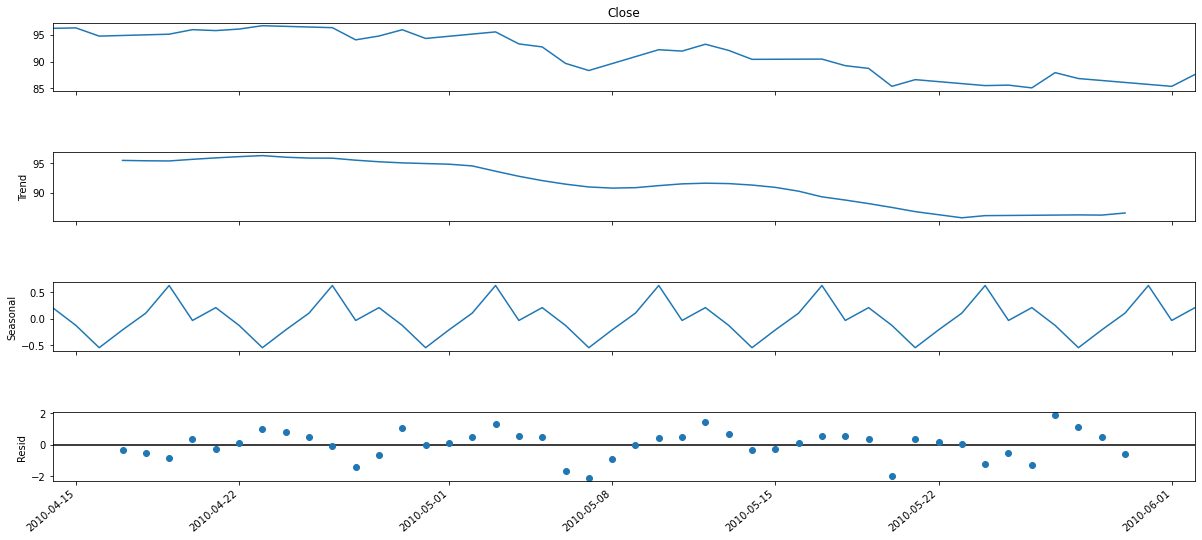

In [602]:
decomposed_fig = seasonal_decompose(df[100:150])
fig = decomposed_fig.plot()
fig.set_size_inches((20, 9))
fig.autofmt_xdate(rotation=40);

It appears like there actually is a seasonal component to the series, for any choice of subset (100:150 is not unique). Let's try to determine its period:

In [603]:
series_period(seasonal_decompose(df).seasonal)

7

 The series repeats every 7 values. This makes sense. The stock market has a forced seasonality of 7 days- as it is open Monday to Friday and is closed on the weekends.

#### Therefore, a SARIMA model might fit this series. This model is very common in econometrics.

### A small tangent regarding outlier detection:
Let's plot the 3-sigma line for the residual component of the series to look at any outliers, using the full df rather than the 2010-2022 set:

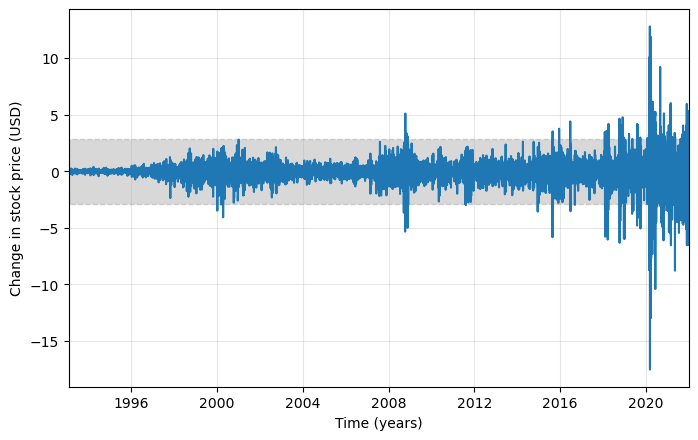

In [1327]:
resid_mean = seasonal_decompose(df_full).resid.mean()
resid_std = seasonal_decompose(df_full).resid.std()

lower = resid_mean - 3 * resid_std
upper = resid_mean + 3 * resid_std

plt.figure(figsize=(8,5), dpi=100)

plt.plot(seasonal_decompose(df_full).resid)

plt.fill_between([df_full.index[0], df_full.index[-1]], lower, upper, color='grey', alpha=0.3, linestyle='--')
plt.xlim(datetime(1993,1,29), datetime(2021, 12, 31))

plt.grid(alpha=0.3)
plt.ylabel('Change in stock price (USD)')
plt.xlabel('Time (years)');

Indeed there are a lot of outliers according to the 3-sigma rule-of-thumb, which correspond to economic events which can be easily googled (Y2K panic in 2000 (or the 2000 tech bubble), the 2008-2009 economic crash, and the covid pandemic starting in 2020, among other events).

This approach can be used to implement a very naive and basic outlier detector.

Now let's go back to the series analysis.

From now, the 2010-2022 set will be used. Let's start with examining the ACF and PACF.

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


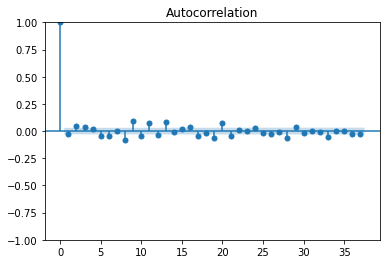

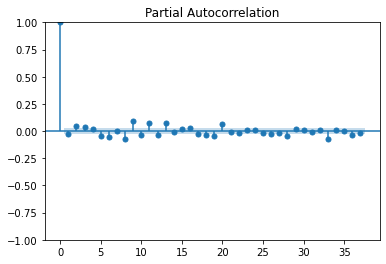

In [604]:
first_diff = diff(df)

plot_acf(first_diff);

# first difference is enough

plot_pacf(first_diff);

### Both ACF and PACF have a structure-less random movement around 0, which means that they are not very informative.

#### Let's check if first difference is enough to make the series stationary with the ADF test:

In [605]:
print('p-value for ADF test:', adfuller(first_diff)[1])

p-value for ADF test: 1.5932485961809353e-26


#### Yes, the first difference is enough, as the p-value is below 0.05.

### Let's write a function that will perform the model fitting and forecast:

In [1126]:
def SARIMA_prediction_data(df_train, df_test, arima_order, sarima_order, model='a'):
    # arima_order is a tuple with 3 values (p, d, q)
    # sarima_order is a tuple with 4 value (P, D, Q, S)
    
    if model == 'a':
        model = ARIMA(df_train, order=arima_order)
    else:
        model = SARIMAX(df_train, order=arima_order, seasonal_order=sarima_order)

    model_fit = model.fit()
    # sigma2 parameter is the estimate of the variance of the error term associated with the time series

    print(model_fit.summary())

    # How many days forward to simulate, match to number of days in testing data
    td = df_test.index[-1] - df_test.index[0]
    n_days = int((td / np.timedelta64(1, 'D'))) + 1

    pred_start_date = df_testing.index[0]
    pred_end_date = df_testing.index[-1]

    #predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
    
    forecast = model_fit.forecast(steps=n_days)
    conf_index = model_fit.get_forecast(n_days).conf_int(alpha=0.05).index # alpha sets confidence interval to 95%
    lower_conf = model_fit.get_forecast(n_days).conf_int(alpha=0.05)['lower Close'].values
    upper_conf = model_fit.get_forecast(n_days).conf_int(alpha=0.05)['upper Close'].values

    plt.figure(figsize=(6,4), dpi=150)
    plt.plot(df_train, label='Training')
    plt.plot(forecast, zorder=5)
    plt.plot(df_test, lw=0.5, label='Testing')
    #plt.plot(test_data, linestyle='--', lw=0.5)
    plt.fill_between(conf_index, lower_conf, upper_conf, color='gray', alpha=0.1)
    plt.legend()
    #plt.ylim(0, 400)
    plt.grid(alpha=0.3)
    plt.ylabel('Stock price (USD)')
    plt.xlabel('Time (years)')
    plt.show()

    return model, model_fit

#### We have the model ready to run, but still not sure what order to use for the model. We already know the series has a seasonality of 7, so we'll use that for the S. And we have to differentiate it at least once, so D is 1.

#### Let's use the brute-force method to try and get an estimate for the SARIMA order:

In [609]:
brute_force_sarima(pd.DataFrame(df_training), 1, 1, 1, S=7)

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


[(2717.358117738021, 'SARIMA(0, 1, 1)x(0, 1, 1, 7)'),
 (2717.436945705521, 'SARIMA(1, 1, 0)x(0, 1, 1, 7)'),
 (2718.634063031373, 'SARIMA(0, 1, 0)x(0, 1, 1, 7)'),
 (2719.288915694311, 'SARIMA(0, 1, 1)x(1, 1, 1, 7)'),
 (2719.3297913593287, 'SARIMA(1, 1, 1)x(0, 1, 1, 7)')]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72114D+00    |proj g|=  2.68888D-01


 This problem is unconstrained.



At iterate    5    f=  1.60658D+00    |proj g|=  4.86597D-02

At iterate   10    f=  1.58835D+00    |proj g|=  4.79843D-03

At iterate   15    f=  1.58678D+00    |proj g|=  3.33928D-04

At iterate   20    f=  1.58662D+00    |proj g|=  9.68970D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     31      1     0     0   4.016D-06   1.587D+00
  F =   1.5866012535276164     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                 

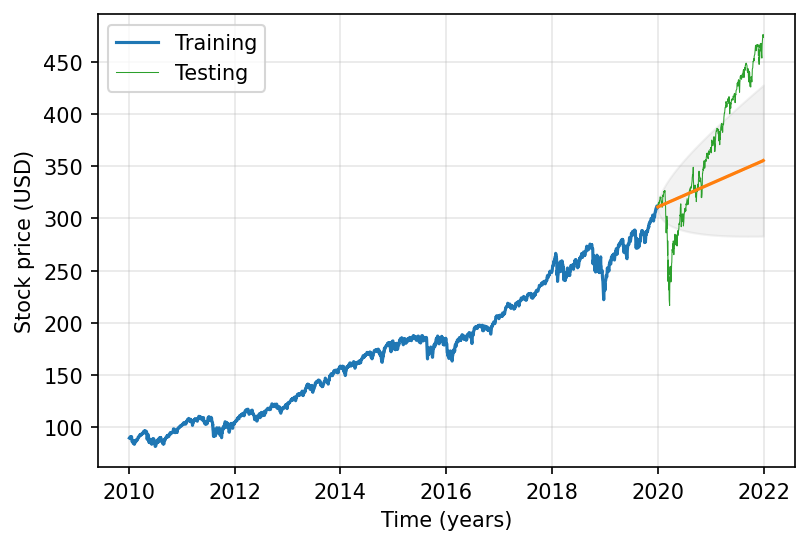

In [1127]:
s_model, s_fit = SARIMA_prediction_data(df_training, df_testing, (0,1,1), (0,1,1,7), model='s')

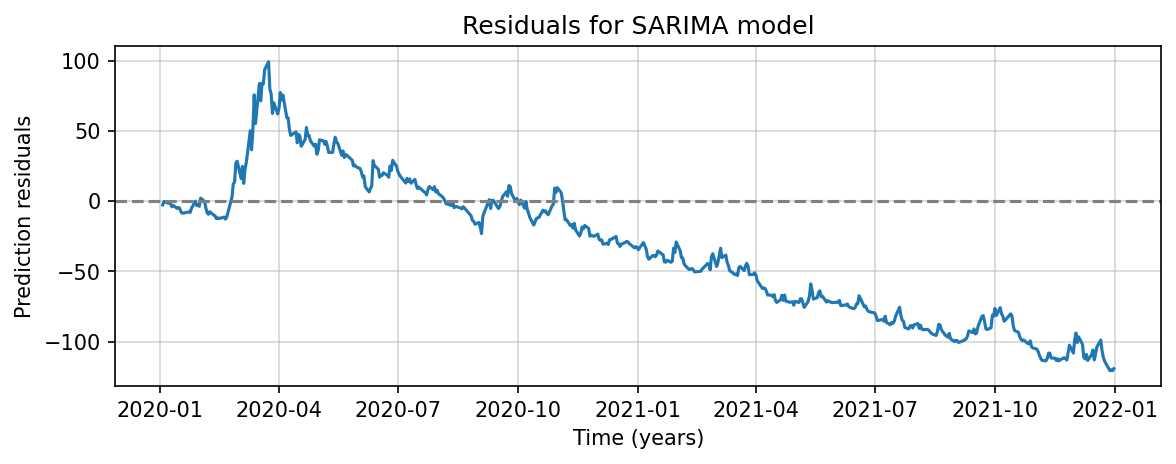

In [1305]:
plt.figure(figsize=(9,3), dpi=150)

plt.title('Residuals for SARIMA model')
plt.plot(df_testing.index[1:], (s_fit.forecast(len(df_testing)) - df_testing).dropna())
plt.axhline(0, color='grey', linestyle='--')
plt.ylabel('Prediction residuals')

plt.grid(alpha=0.5)
plt.xlabel('Time (years)')
plt.show()

In [1300]:
shapiro((s_fit.forecast(len(df_testing)) - df_testing).dropna())

ShapiroResult(statistic=0.9669233560562134, pvalue=8.969794525193198e-12)

#### This is not too bad. Recall that for a very noisy series the model prediction converges on the series average trend for longer prediction periods.

#### Maybe an ARIMA model might also be able to produce similar results?

In [611]:
auto_arima(df_training)

ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)

In [1185]:
brute_force_sarima(df[:covid_recovery_date], 2, 2, 2, S=7)

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alon/opt/

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/st

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alon/opt/anaconda3/lib/python3.9/site-packages/st

[(68.95622257448358, 'SARIMA(1, 0, 1)x(2, 0, 2, 7)'),
 (3036.5023366538535, 'SARIMA(1, 1, 0)x(1, 1, 2, 7)'),
 (3036.639402711755, 'SARIMA(0, 1, 1)x(1, 1, 2, 7)'),
 (3036.698448588726, 'SARIMA(1, 1, 0)x(2, 1, 2, 7)'),
 (3036.7824051843118, 'SARIMA(0, 1, 1)x(2, 1, 2, 7)')]

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.96205D+00    |proj g|=  1.99065D-01

At iterate    5    f=  1.86669D+00    |proj g|=  3.89653D-02

At iterate   10    f=  1.86296D+00    |proj g|=  1.30215D-03

At iterate   15    f=  1.86286D+00    |proj g|=  1.42110D-04

At iterate   20    f=  1.86286D+00    |proj g|=  3.49432D-04

At iterate   25    f=  1.86261D+00    |proj g|=  6.93944D-03

At iterate   30    f=  1.86244D+00    |proj g|=  3.26936D-03

At iterate   35    f=  1.86238D+00    |proj g|=  1.07930D-04

At iterate   40    f=  1.86237D+00    |proj g|=  1.38815D-04

At iterate   45    f=  1.86237D+00    |proj g|=  8.53131D-05

At iterate   50    f=  1.86237D+00    |proj g|=  1.18351D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/alon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                       SARIMAX Results                                        
Dep. Variable:                                  Close   No. Observations:                 3741
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2], 7)   Log Likelihood               -6967.128
Date:                                Wed, 13 Apr 2022   AIC                          13944.257
Time:                                        20:28:49   BIC                          13975.382
Sample:                                    01-04-2010   HQIC                         13955.329
                                         - 04-01-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0339      0.003     -9.687      0.000      -0.041      -0.027
ar.

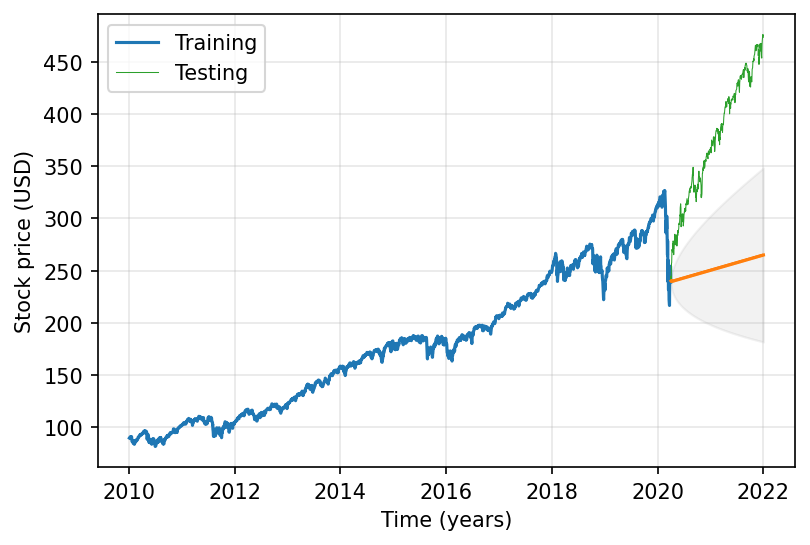

(<statsmodels.tsa.statespace.sarimax.SARIMAX at 0x7fcb5dce1400>,
 <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7fcb8869eeb0>)

In [1286]:
SARIMA_prediction_data(df[:covid_recovery_date], df[covid_recovery_date:], (1,1,0), (1,1,2,7), model='s')

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3649
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -5781.469
Date:                Wed, 13 Apr 2022   AIC                          11568.939
Time:                        19:26:00   BIC                          11587.544
Sample:                    01-04-2010   HQIC                         11575.565
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0567      0.009      6.316      0.000       0.039       0.074
ma.L1         -0.9994      0.002   -510.755      0.000      -1.003      -0.996
sigma2         1.3921      0.015     90.993      0.0

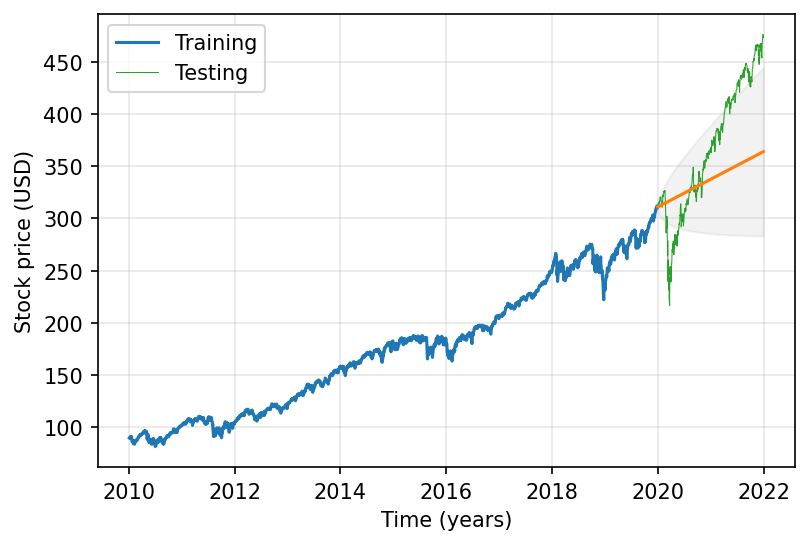

In [1156]:
# Despite the auto_arima method recommending an ARIMA(1,1,0) model, it does not fit the data very well.
# After some tries, it is evident that an ARIMA(1,2,1) model yields good prediction, so we'll stick with that.
a_model, a_fit = SARIMA_prediction_data(df_training, df_testing, (1,2,1), None, model='a')

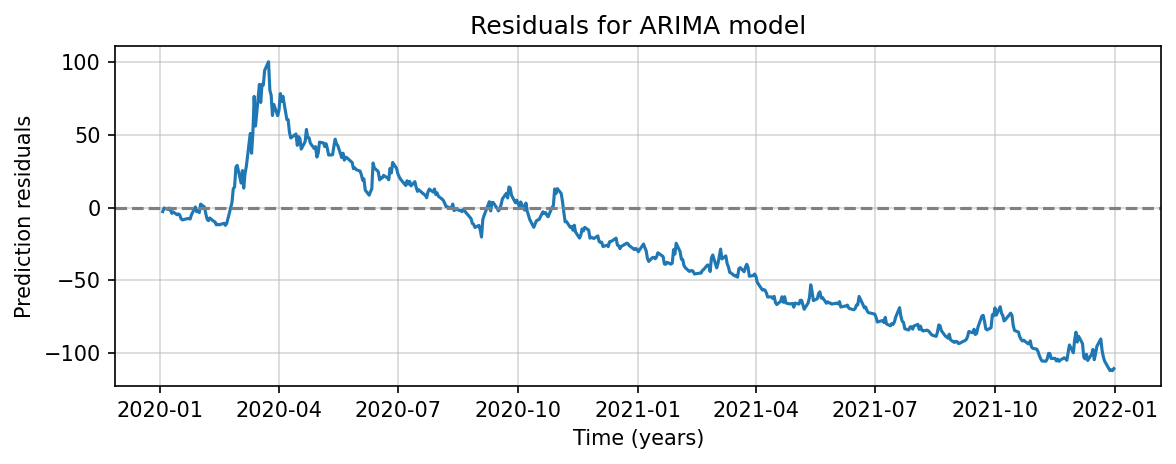

In [1306]:
plt.figure(figsize=(9,3), dpi=150)

plt.title('Residuals for ARIMA model')
plt.plot(df_testing.index[1:], (a_fit.forecast(len(df_testing)) - df_testing).dropna())
plt.axhline(0, color='grey', linestyle='--')
plt.ylabel('Prediction residuals')

plt.grid(alpha=0.5)
plt.xlabel('Time (years)')
plt.show()

In [1299]:
shapiro((a_fit.forecast(len(df_testing)) - df_testing).dropna())

ShapiroResult(statistic=0.9678618907928467, pvalue=1.4502965668683476e-11)

#### Both models seem to be producing very similar results. Let's plot them on the same graph for a visual comparison:

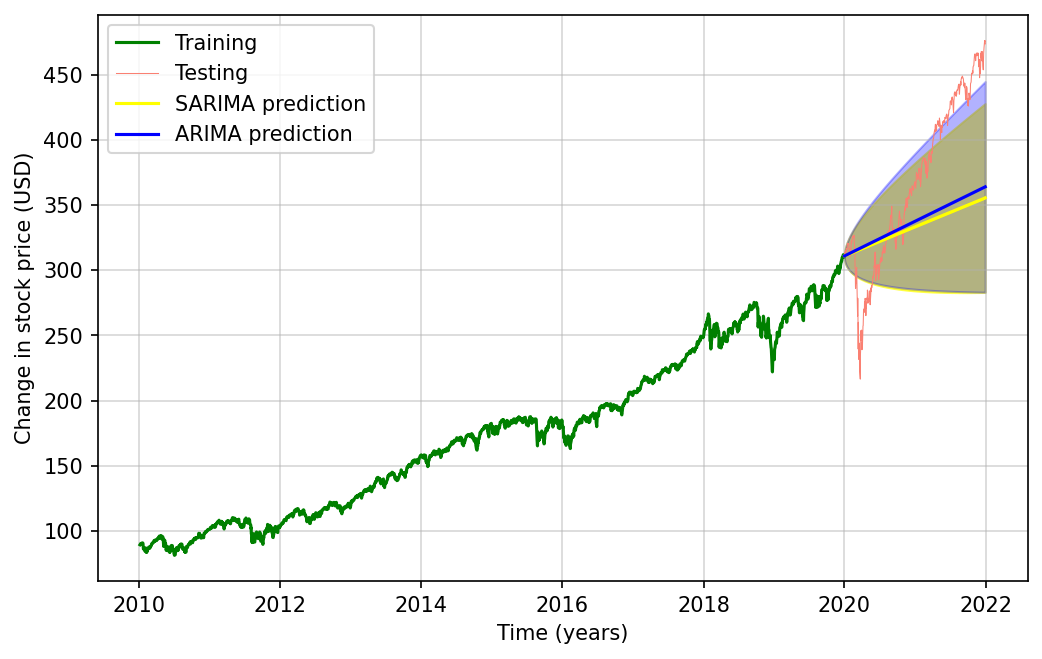

In [667]:
n_days = len(df_testing)

plt.figure(figsize=(8,5), dpi=150)
plt.plot(df_training, color='green', label='Training')
plt.plot(df_testing, color='salmon', lw=0.5, label='Testing')

# Plot predictions
plt.plot(s_fit.forecast(n_days), label='SARIMA prediction', color='yellow')
plt.plot(a_fit.forecast(n_days), label='ARIMA prediction', color='blue')

# Confidence interval for sarima
s_conf = s_fit.get_forecast(n_days).conf_int(alpha=0.05)
s_lower = s_conf['lower Close']
s_upper = s_conf['upper Close']
plt.fill_between(s_conf.index, s_lower, s_upper, color='yellow', alpha=0.7)

# Confidence interval for arima
a_conf = a_fit.get_forecast(n_days).conf_int(alpha=0.05)
a_lower = a_conf['lower Close']
a_upper = a_conf['upper Close']

plt.fill_between(a_conf.index, a_lower, a_upper, color='blue', alpha=0.3)


plt.legend()
plt.grid(alpha=0.5)
plt.ylabel('Change in stock price (USD)')
plt.xlabel('Time (years)')
plt.show()

Indeed, very similar results. Looking back at the series decomposition, the amplitude of the seasonal component is smaller than that of the residual component, which means that the seasonality of the series is negligible compared to the unexplained noise (residual) component.

#### Recalling that simpler models are favoured, it would be preferable to stick to the ARIMA model in this case.
<br>
<br>

Next, let's use a MCMC approach to get a better estimate of the probability distributions of the 3 parameters in our ARIMA model:

$\phi_1$ for the AR(1) part, $\theta_1$ for the MA(1) part, and $\sigma$ for the estimate of the standard deviation in the residual noise.

The ARIMA model predicted the following values: </br>
$\phi_1$ ~ 0.0567 </br>
$\theta_1$ ~ -0.9994 </br>
$\sigma$ ~ 1.3921

In [668]:
# Define the likelihood, prior, and posterior functions

def log_likelihood(params, model):
    # the computed model has a built in log likelihood function we can use
    return model.loglike(params)

def log_prior(params):
    p, q, sigma = params
    # A uniform prior distribution for all three parameters
    if -0.5 < p < 0.5 and -1.5 < q < 0 and 1 < sigma < 2:
        return 0.0
    return -np.inf

def log_post(params, model):
    lp = log_prior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, model)

In [672]:
num_iter = 3000
ndim = 3 # number of parameters
nwalkers =  30

# initial position for each walker should be varied a little to allow a more broad distribution of walks
initial_pos = np.array((0,-0.5,1.5)) + 0.01 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=[a_model])

sampler.run_mcmc(initial_pos, num_iter, progress=True);

100%|███████████████████████████████████████| 3000/3000 [08:24<00:00,  5.95it/s]


In [673]:
samples = sampler.get_chain()

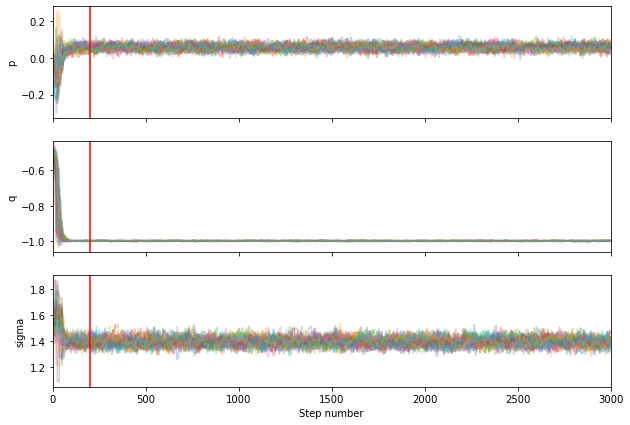

In [706]:
f, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["p", "q", "sigma"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.axvline(200, color='red') # Burn-in period to be removed

axes[-1].set_xlabel("Step number");

In [675]:
# Discard burn-in period and thin the sample
flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)

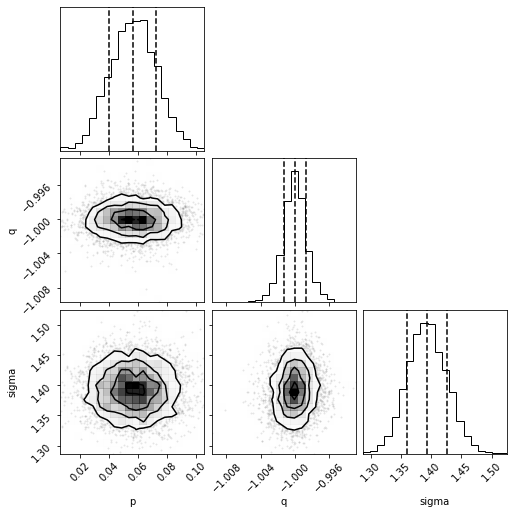

In [676]:
fig = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84]);

In [678]:
# get the mean of the estimates for each parameter

p_mc = flat_samples[:,0].mean() # p
print(p_mc)

q_mc = flat_samples[:,1].mean() # q
print(q_mc)

sig_mc = flat_samples[:,2].mean() # sigma
print(sig_mc)

0.05664347207286578
-1.0000334251583378
1.3932530740229676


### The mean of the estimates determined through MCMC all fall within the error of the values determined by the ARIMA model. Let's sample some of the MCMC-determined parameters and see how the predictions compare to ARIMA.

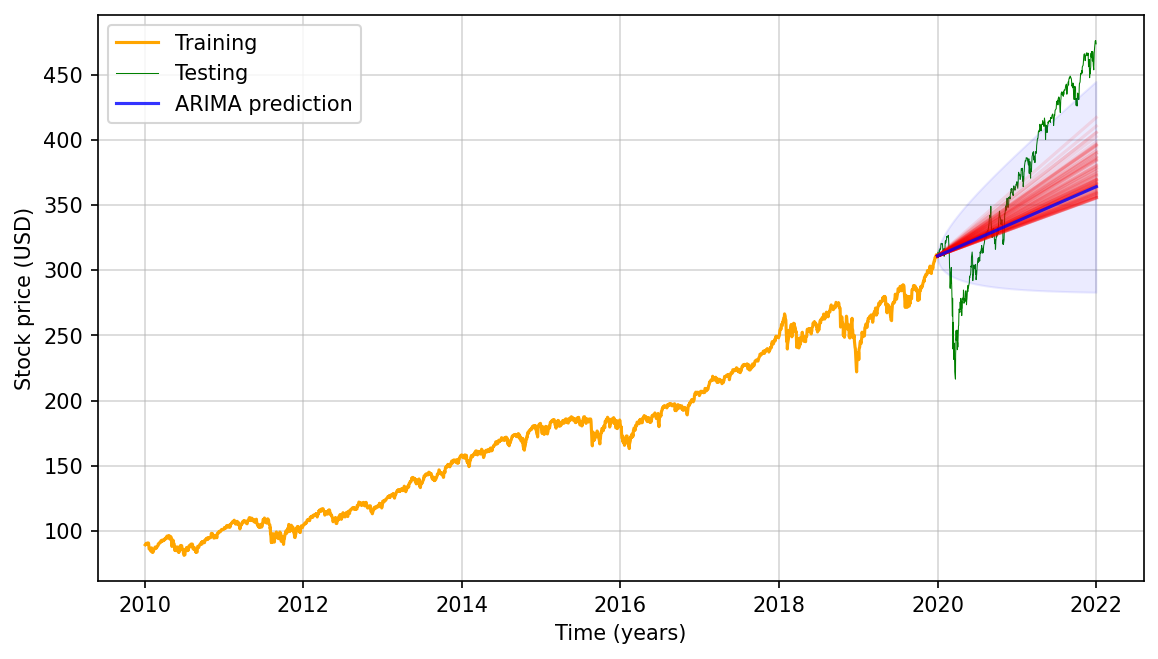

In [699]:
plt.figure(figsize=(9,5), dpi=150)

plt.plot(df_training, color='orange', label='Training')
plt.plot(df_testing, color='green', lw=0.5, label='Testing')

#plt.plot(a_fit.simulate(len(df_testing), anchor='end'), color='green')
plt.plot(a_fit.predict(start='2020-1-1', end='2022-1-1'), color='blue', alpha=0.8, label='ARIMA prediction', zorder=6)
# Confidence interval for arima
plt.fill_between(a_conf.index, a_lower, a_upper, color='blue', alpha=0.08, zorder=4)

# How many samples to get from the mcmc samples
inds = np.random.randint(len(flat_samples), size=100)

for ind in inds:
    sample = flat_samples[ind]
        #fix params of fit to the ones determined by mcmc algo
    with a_model.fix_params({'ar.L1': sample[0], 'ma.L1': sample[1], 'sigma2': sample[2]}):
        mcmc_fit = a_model.fit()
    
        #plt.plot(mcmc_model_fit.simulate(len(df_testing), anchor='end'), alpha=0.1, color='red')
        plt.plot(mcmc_fit.predict(start='2020-1-1', end='2022-1-1'), color='red', alpha=0.1, zorder=5)


plt.legend()
plt.grid(alpha=0.5)
plt.ylabel('Stock price (USD)')
plt.xlabel('Time (years)')
plt.show()

Overall, both methods are within agreement of each other, but it appears as though ARIMA chooses parameters which predict a lower trend from the range of MCMC predictions. That's where MCMC has an advantage over a traditional time-series model- we are more informed about the probability distribution from which the model parameters are chosen.

The approach above supplies very broad ranges of predictions due to nature of the ARIMA model. As the period of prediction into the future increases, each subsequent point uses previously predicted points, causing the uncertainty to rise quickly.

An alternative approach to time series prediction, which is more realistic, is using a <b> rolling forecasting procedure </b> approach. In this method, a very small period is predicted into the future, and then after the month passes, the real data is used to predict the next month, and so on. This is a more common approach which is actually used in practice, as stakeholders are often interested in a more reliable short-term prediction, rather than a far-into-the-future one.

In [1149]:
#test_freq takes 'D' for daily, 'W' for week or 'M' for month
def ARIMA_predict_interval(df_test, test_freq, df_train):
    n_days = len(df_test)

    # Define number of prediction steps based on testing set frequency
    if test_freq == 'M':
        n_steps = 30
    if test_freq == 'W':
        n_steps = 7
    if test_freq == 'D':
        n_steps = 1
        
    predictions = {}

    df_rolling_training = pd.DataFrame(df_train.copy())

    df_predicted = pd.DataFrame([], columns=['Date', 'Close'])
    df_predicted.index = pd.to_datetime(df_predicted['Date'])
    df_predicted = df_predicted.drop(['Date'], axis=1)

    for index, row in pd.DataFrame(df_test).asfreq(test_freq).iterrows():

        #print('### Iteration Marker ###')
        rolling_fit = ARIMA(df_rolling_training.asfreq('D'), order=(1,2,1)).fit()

        curr_pred = pd.DataFrame(rolling_fit.forecast(steps=n_steps))
        curr_pred.index = pd.to_datetime(curr_pred.index)
        curr_pred.columns = ['Close']

        df_predicted = df_predicted.append(curr_pred)

        if test_freq == 'D':
            df_rolling_training = df_rolling_training.append(pd.DataFrame(row).transpose())
        else:
            df_rolling_training = df_rolling_training.append(pd.DataFrame(df_test[curr_pred.index[0]:curr_pred.index[-1]]))
        
        del curr_pred

    return df_predicted

In [ ]:
daily_ARIMA_prediction_df = ARIMA_predict_interval(df_testing[:20], 'D', df_training)

In [1118]:
daily_ARIMA_prediction_df

,Close
2020-01-01,310.948800
2020-01-03,313.886401
2020-01-04,311.295285
2020-01-05,311.854965
2020-01-06,312.240963
...,...
2021-12-27,474.261896
2021-12-28,475.925345
2021-12-29,475.587692
2021-12-30,476.171229


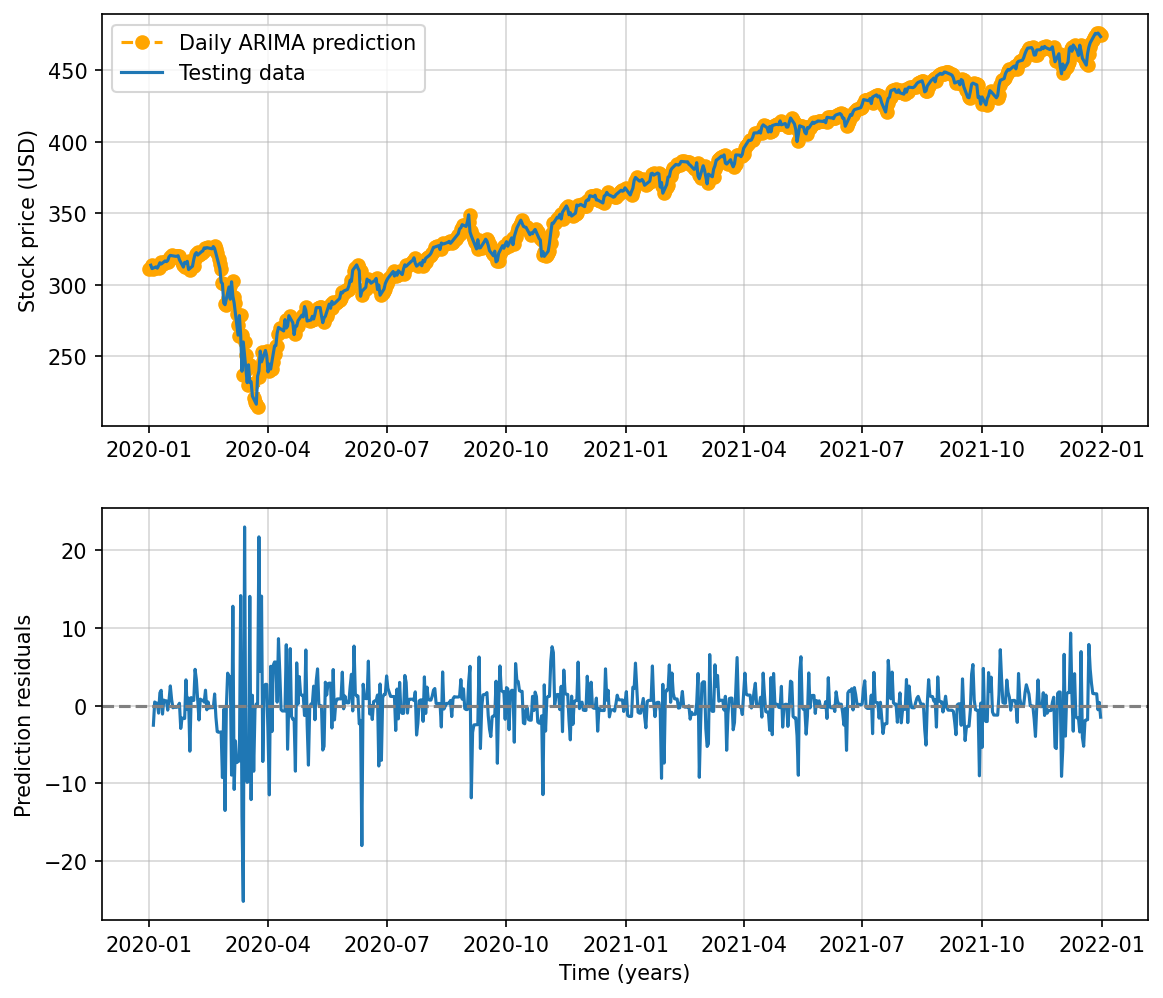

In [1210]:
plt.figure(figsize=(9,8), dpi=150)

ax1 = plt.subplot(211)
ax1.plot(daily_ARIMA_prediction_df.index, daily_ARIMA_prediction_df['Close'], 
            color='orange', marker='o', linestyle='dashed', label='Daily ARIMA prediction')

ax1.plot(df_testing, label='Testing data')
plt.ylabel('Stock price (USD)')
plt.legend()
plt.grid(alpha=0.5)

ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(df_testing.index, (df_testing - daily_ARIMA_prediction_df['Close'])[:-1])
ax2.axhline(0, color='grey', linestyle='--')
plt.ylabel('Prediction residuals')


plt.grid(alpha=0.5)

plt.xlabel('Time (years)')
plt.show()

In [1292]:
shapiro((df_testing - daily_ARIMA_prediction_df['Close']).dropna())
# pvalue << 0.5 => residuals NOT normally distributed

ShapiroResult(statistic=0.8631223440170288, pvalue=1.06647338371993e-24)

In [1090]:
weekly_ARIMA_prediction_df = ARIMA_predict_interval(df_testing, 'W', df_training)

### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###


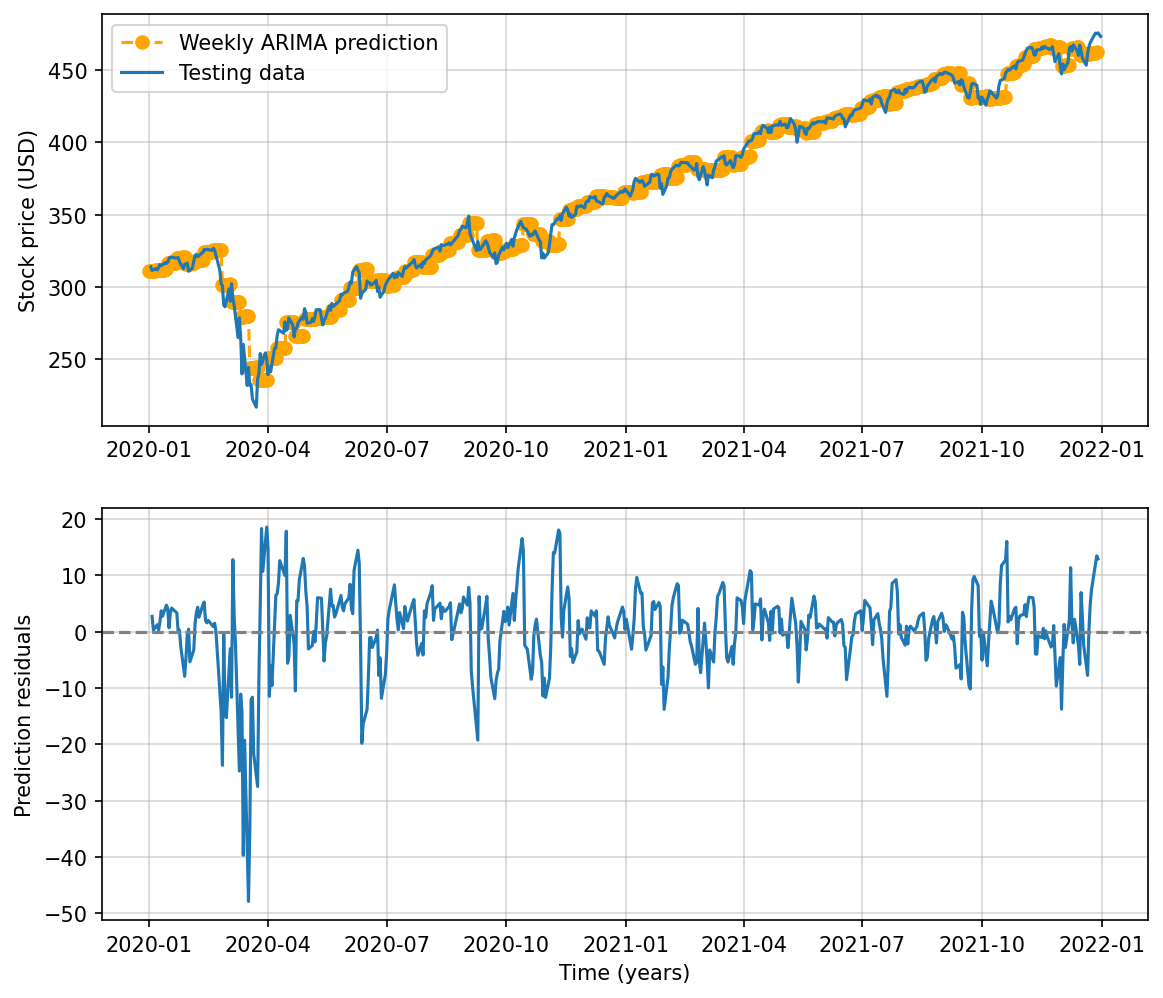

In [1209]:
plt.figure(figsize=(9,8), dpi=150)


ax1 = plt.subplot(211)
ax1.plot(weekly_ARIMA_prediction_df.index, weekly_ARIMA_prediction_df['Close'], 
            color='orange', marker='o', linestyle='dashed', label='Weekly ARIMA prediction')

ax1.plot(df_testing, label='Testing data')

plt.legend()
plt.grid(alpha=0.5)
plt.ylabel('Stock price (USD)')

ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(df_testing.index, (df_testing - weekly_ARIMA_prediction_df['Close'])[:-1])
ax2.axhline(0, color='grey', linestyle='--')
plt.ylabel('Prediction residuals')


plt.grid(alpha=0.5)

plt.xlabel('Time (years)')
plt.show()

In [1293]:
shapiro((df_testing - weekly_ARIMA_prediction_df['Close']).dropna())
# pvalue << 0.5 => residuals NOT normally distributed

ShapiroResult(statistic=0.90529865026474, pvalue=8.049463369609004e-21)

In [1092]:
monthly_ARIMA_prediction_df = ARIMA_predict_interval(df_testing, 'M', df_training)

### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###
### Iteration Marker ###


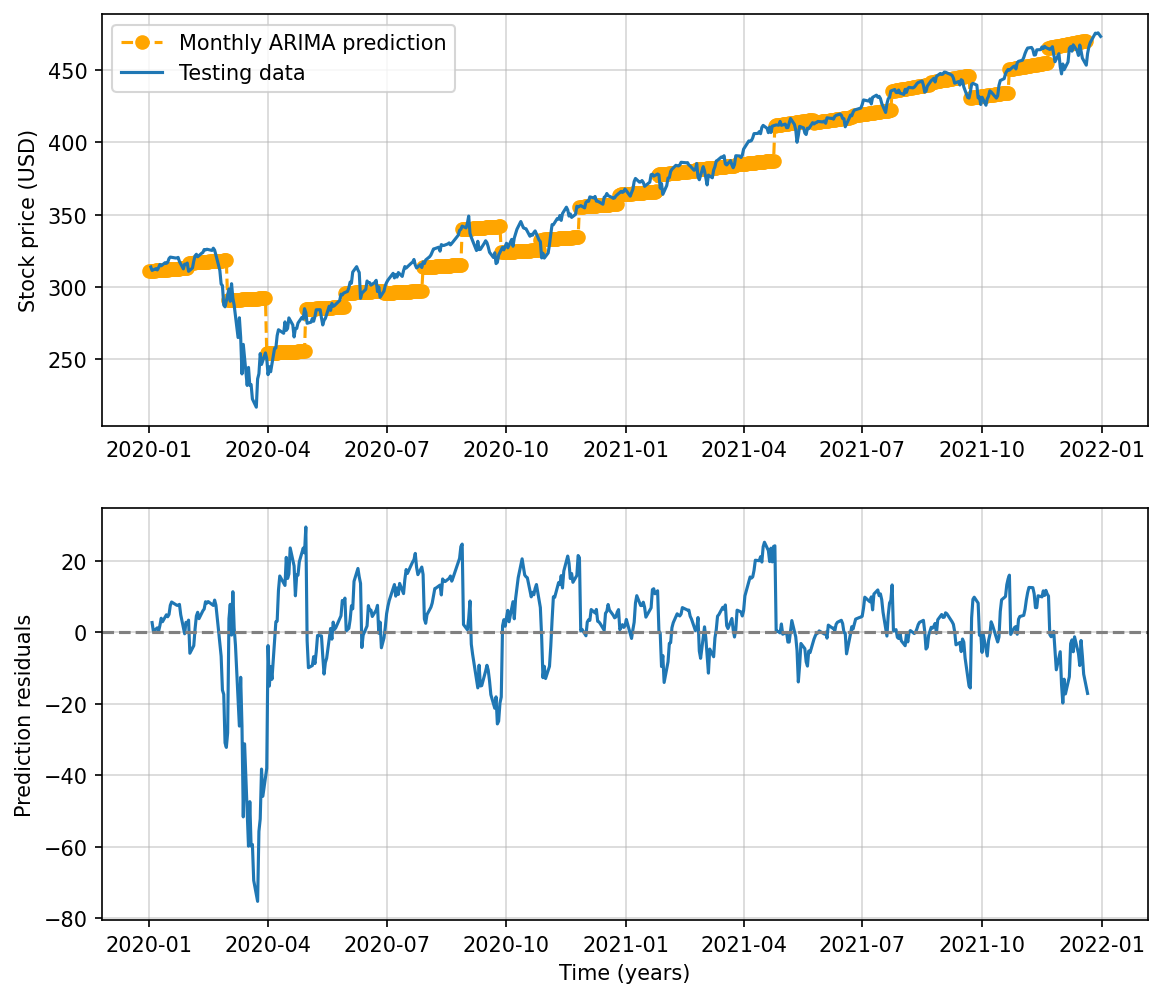

In [1208]:
plt.figure(figsize=(9,8), dpi=150)

ax1 = plt.subplot(211)
ax1.plot(monthly_ARIMA_prediction_df.index, monthly_ARIMA_prediction_df['Close'], 
            color='orange', marker='o', linestyle='dashed', label='Monthly ARIMA prediction')

ax1.plot(df_testing, label='Testing data')

plt.legend()
plt.grid(alpha=0.5)
plt.ylabel('Stock price (USD)')


ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(df_testing.index, (df_testing - monthly_ARIMA_prediction_df['Close'])[:-1])
ax2.axhline(0, color='grey', linestyle='--')
plt.ylabel('Prediction residuals')


plt.grid(alpha=0.5)

plt.xlabel('Time (years)')
plt.show()

In [1294]:
shapiro((df_testing - monthly_ARIMA_prediction_df['Close']).dropna())
# pvalue << 0.5 => residuals NOT normally distributed

ShapiroResult(statistic=0.834922730922699, pvalue=1.2852628772622087e-26)

If there is time left,  I will add some unit tests for my functions below:

In [1328]:
def add(a, b):
    return a + b

In [1331]:
import unittest

class TestNotebook(unittest.TestCase):
    
    def test_add(self):
        self.assertEqual(add(2, 2), 4)
        

unittest.main(argv=[''], verbosity=2, exit=False)

test_add (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


### Report structure:

#### Intro
    Describe problem
        Why predict TS, examples (weather, economics, supply&demand of a store, etc.)
        
        Predictable vs. unpredictable
        
    Provide BG
        Decomposition (Structural Time Series)
            seasonality
            trend
            residuals
        Differencing
        Stationarity
        ADF
        Shapiro-Wilk test
        ACF
        PACF
        AR
        MA
        ARIMA
        AIC
        SARIMA
        order selection (ACF, PACF, brute force)
        Rolling forecast
        

#### Body

    Data
        Weather data (temps) are very predictable (explain why, b/c of decomposition), where data was obtained, how it was processes, cleaned, etc.

        Stock data is very UNpredictable (explain why, 500 companies, each with own fluctuations, very weak seasonal component, mostly noise and trend), API, interpolation to remove missing values, etc.

    Methods
        Weather data: SARIMA
        
        Stocks: SARIMA vs. ARIMA, both produce very similar results, so go with ARIMA.
             Then, MCMC Metropolis-Hastings algo to get a better understanding of parameters

#### Results

#### Prediction vs testing set, residuals

    Weather: original + trended data
    
    Stocks: SARIMA, ARIMA, MCMC (predictions + parameter distributions), rolling forecast(day vs week vs month) 


#### Conclusion

choosing time series model (sarima order) is not deterministic, and doesn't only depend on one parameter or another, choosing it comes down to being the call of the person doing the prediction.

Predicting stocks is very difficult (google why)(rule about predicting future inherently changes it, making the prediction wrong?)



reddit quote:
First, volatility clusters. That is, high volatility yesterday tends to imply high volatility today. Second, volatility is path-dependent. For most stocks, if the price declines significantly, then the danger of bankruptcy increases as does future volatility.